<a href="https://colab.research.google.com/github/SN-NGOBESE/Exam/blob/main/Exam_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SN Ngobese 22356737

IN this not book (exam) i have fully codded using python 3xxxxxx and the datasets that i used a factual datasets i sourced both of them on openAfrica wich is an open  data  source.
Multi realtional Crime Incidents dataset: https://open.africa/dataset/police-crime-stats-south-africa/resource/5ba84233-e9ce-4819-ab45-7bf34aa21153

Contextual dataset link :  https://bulk.openafrica.net/sv/dataset/community-survey-south-africa-2016/resource/53b6e7de-522e-4ee9-8b1e-7a0d695d39b0

they are both factual

my datasets are mostly clean but i did check that first and also dropped unnecessary columns including empty columns and rows.


In [ ]:
CRIME_XLSX = "/content/drive/MyDrive/crime-statistics-20152016.xlsx"
POP_CSV    = "/content/drive/MyDrive/cfafrica-_-data-team-_-covid-19-_-data-_-openafrica-uploads-_-south-africa-population-density (1).csv"

features from previous year (avoid leakage)

In [ ]:
FEATURE_YEAR = "2014-2015"

label hotspots on this year

In [ ]:
TARGET_YEAR  = "2015-2016"

top 25% = hotspot

In [ ]:
HOTSPOT_TOP_QUANTILE = 0.75

2 years (~24 months) at annual cadence

In [ ]:
FORECAST_CATEGORY = "Burglary at residential premises"
FORECAST_PROVINCE = "Gauteng"
FORECAST_YEARS_AHEAD = 2
RANDOM_SEED = 42

IMPOPRT IMPORTANT OR NECCESSARY LIBRARIES

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc


from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing

HELPER FUNCTIONS AND Drop Unnamed columns and strip column names.

In [ ]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    drop_cols = [c for c in df.columns if c.lower().startswith("unnamed")]
    return df.drop(columns=drop_cols, errors="ignore")

In [ ]:
def strip_strings(df: pd.DataFrame, cols) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()
    return df

In [ ]:
def coerce_numeric(df: pd.DataFrame, cols) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

Convert '2015-2016' -> 2016 (int).

In [ ]:
def end_year(label: str):
    m = re.match(r"^(\d{4})-(\d{4})$", str(label))
    return int(m.group(2)) if m else None

LOAD & CLEAN CRIME DATA

In [ ]:
print("Loading crime workbook…")
xls = pd.ExcelFile(CRIME_XLSX)
stations = pd.read_excel(xls, sheet_name="Stations")
stations = clean_columns(stations)


Loading crime workbook…


Identify year columns like "2005-2006

In [ ]:
year_cols = [c for c in stations.columns if re.fullmatch(r"\d{4}-\d{4}", c)]
if FEATURE_YEAR not in year_cols or TARGET_YEAR not in year_cols:
    raise ValueError(f"Feature/target years not found. Year columns present: {year_cols}")


Keep core columns and clean

In [ ]:
keep_cols = ["Station", "Province", "Crime Category"] + year_cols
stations = stations[keep_cols].copy()
stations = strip_strings(stations, ["Station", "Province", "Crime Category"])
stations = coerce_numeric(stations, year_cols)
stations = stations.dropna(subset=["Station", "Crime Category"])
stations = stations.drop_duplicates(subset=["Station", "Province", "Crime Category"] + year_cols)

print("Crime dataset shape after cleaning:", stations.shape)
print(stations.head(3), "\n")

Crime dataset shape after cleaning: (31131, 14)
    Station      Province                                     Crime Category  \
0  Aberdeen  Eastern Cape                  All theft not mentioned elsewhere   
1  Aberdeen  Eastern Cape                                              Arson   
2  Aberdeen  Eastern Cape  Assault with the intent to inflict grievous bo...   

   2005-2006  2006-2007  2007-2008  2008-2009  2009-2010  2010-2011  \
0         63         54         38         41         43         31   
1          0          0          0          0          2          3   
2         79         88         70         69         67         53   

   2011-2012  2012-2013  2013-2014  2014-2015  2015-2016  
0         43         30         31         38         51  
1          0          1          2          2          4  
2         62         57         54         78         87   



Aggregate (safety) and compute totals per station by year

In [ ]:
df = stations.groupby(["Station", "Province", "Crime Category"], as_index=False)[year_cols].sum()
totals_by_station = df.groupby(["Station", "Province"])[year_cols].sum().reset_index()


HOTSPOT LABEL (Top 25% by 2015–2016 total)

In [ ]:
cut = totals_by_station[TARGET_YEAR].quantile(HOTSPOT_TOP_QUANTILE)
totals_by_station["is_hotspot"] = (totals_by_station[TARGET_YEAR] >= cut).astype(int)
print(f"Hotspot threshold (top {int((1-HOTSPOT_TOP_QUANTILE)*100)}% coverage) = {cut:.0f}")
print("Hotspot share =", totals_by_station["is_hotspot"].mean())

Hotspot threshold (top 25% coverage) = 2553
Hotspot share = 0.25065047701647875


FEATURES FROM PRIOR YEAR (COUNTS + PROPORTIONS)

In [ ]:
features_wide = df.pivot_table(
    index=["Station", "Province"],
    columns="Crime Category",
    values=FEATURE_YEAR,
    aggfunc="sum",
    fill_value=0
)
station_total_prev = features_wide.sum(axis=1).replace(0, 1)
X_counts = features_wide.add_suffix("_count")
X_props  = features_wide.div(station_total_prev, axis=0).add_suffix("_prop")
X_all    = pd.concat([X_counts, X_props], axis=1)
data = X_all.join(
    totals_by_station.set_index(["Station", "Province"])[["is_hotspot"]],
    how="inner"
).reset_index()

X = data.drop(columns=["is_hotspot", "Station", "Province"])
y = data["is_hotspot"]

print("\nFeature matrix shape:", X.shape, "| Positive rate:", y.mean())


Feature matrix shape: (1153, 54) | Positive rate: 0.25065047701647875


LOAD & CLEAN CONTEXTUAL POPULATION-DENSITY

In [ ]:
print("\nLoading population-density CSV…")
pop = pd.read_csv(POP_CSV)
pop = clean_columns(pop)

for col in ["geo_code", "geo_level", "name"]:
    if col in pop.columns:
        pop[col] = pop[col].astype(str).str.strip()

num_cols = [c for c in ["population", "square_kms", "population_density"] if c in pop.columns]
pop = coerce_numeric(pop, num_cols)
pop = pop.drop_duplicates()

print("Population-density rows after cleaning:", pop.shape[0])
print("Geo levels present:", pop["geo_level"].dropna().unique() if "geo_level" in pop.columns else "N/A")
print(pop.head(3), "\n")



Loading population-density CSV…
Population-density rows after cleaning: 267
Geo levels present: ['municipality' 'district' 'province' 'country']
  geo_code     geo_level  geo_version         name  population   square_kms  \
0     5263  municipality          NaN    Abaqulusi      243795   4184.63000   
1     5238  municipality          NaN  Alfred Duma      356274   3764.00000   
2      244      district          NaN   Alfred Nzo      867864  10800.59213   

   population_density  
0           58.259631  
1           94.653029  
2           80.353372   



OPTIONAL province-level merge if available (won't error if not found) And Rebuild X with contextual feature

In [ ]:
merged_context_ok = False
if "geo_level" in pop.columns and pop["geo_level"].str.lower().eq("province").any():
    # If dataset includes province rows, merge on province name
    prov_df = pop[pop["geo_level"].str.lower() == "province"].copy()
    prov_df["Province_norm"] = prov_df["name"].str.lower()
    data["Province_norm"] = data["Province"].str.lower()
    data_ctx = data.merge(
        prov_df[["Province_norm", "population_density"]],
        on="Province_norm",
        how="left"
    ).drop(columns=["Province_norm"])
     # Rebuild X with contextual feature
    X = data_ctx.drop(columns=["is_hotspot", "Station", "Province"])
    X["population_density"] = X["population_density"].fillna(X["population_density"].median())
    merged_context_ok = True
    print("Contextual feature 'population_density' merged at province level.")
else:
    print("No province-level rows in population CSV. Proceeding without merging contextual data.")


Contextual feature 'population_density' merged at province level.


TRAIN/TEST & MODELS

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_SEED
)


 Logistic Regression (scaled)

In [ ]:
logit = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=400, random_state=RANDOM_SEED))
logit.fit(X_train, y_train)
y_prob_log = logit.predict_proba(X_test)[:, 1]
y_pred_log = (y_prob_log >= 0.5).astype(int)

[CLASSIFICATION – LOGIT/RF] ROC curves

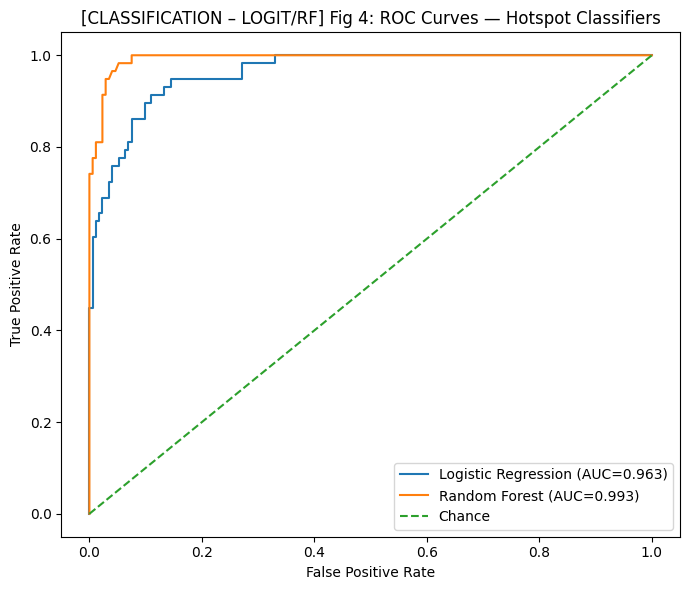

In [ ]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_prob_rf)
auc_log = auc(fpr_log, tpr_log)
auc_rf  = auc(fpr_rf,  tpr_rf)

fig4 = plt.figure(figsize=(7,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC={auc_log:.3f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC={auc_rf:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Chance")
plt.title("[CLASSIFICATION – LOGIT/RF] Fig 4: ROC Curves — Hotspot Classifiers")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend(); plt.tight_layout()
maybe_save(fig4, "fig4_classification_roc.png")
plt.show()

Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight="balanced",
    random_state=RANDOM_SEED
)
rf.fit(X_train, y_train)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_prob_rf >= 0.5).astype(int)

def brief_report(name, y_true, y_prob, y_pred):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, digits=3))
    print("AUC:", round(roc_auc_score(y_true, y_prob), 3))

brief_report("Logistic Regression", y_test, y_prob_log, y_pred_log)
brief_report("Random Forest",      y_test, y_prob_rf, y_pred_rf)


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.941     0.925     0.933       173
           1      0.787     0.828     0.807        58

    accuracy                          0.900       231
   macro avg      0.864     0.876     0.870       231
weighted avg      0.902     0.900     0.901       231

AUC: 0.963

=== Random Forest ===
              precision    recall  f1-score   support

           0      0.982     0.971     0.977       173
           1      0.917     0.948     0.932        58

    accuracy                          0.965       231
   macro avg      0.950     0.960     0.954       231
weighted avg      0.966     0.965     0.966       231

AUC: 0.993


Show most important features (RF)

In [ ]:
rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 15 RF features:")
print(rf_importance.head(15))



Top 15 RF features:
Malicious damage to property_count                       0.137987
All theft not mentioned elsewhere_count                  0.130431
Robbery with aggravating circumstances_count             0.096008
Common robbery_count                                     0.084187
Common assault_count                                     0.077254
Theft out of or from motor vehicle_count                 0.076137
Theft of motor vehicle and motorcycle_count              0.047673
Burglary at residential premises_count                   0.040217
Commercial crime_count                                   0.035396
Driving under the influence of alcohol or drugs_count    0.034170
Shoplifting_count                                        0.029333
Burglary at non-residential premises_count               0.025512
Robbery at non-residential premises_count                0.025421
Drug-related crime_count                                 0.019014
Carjacking_count                                       

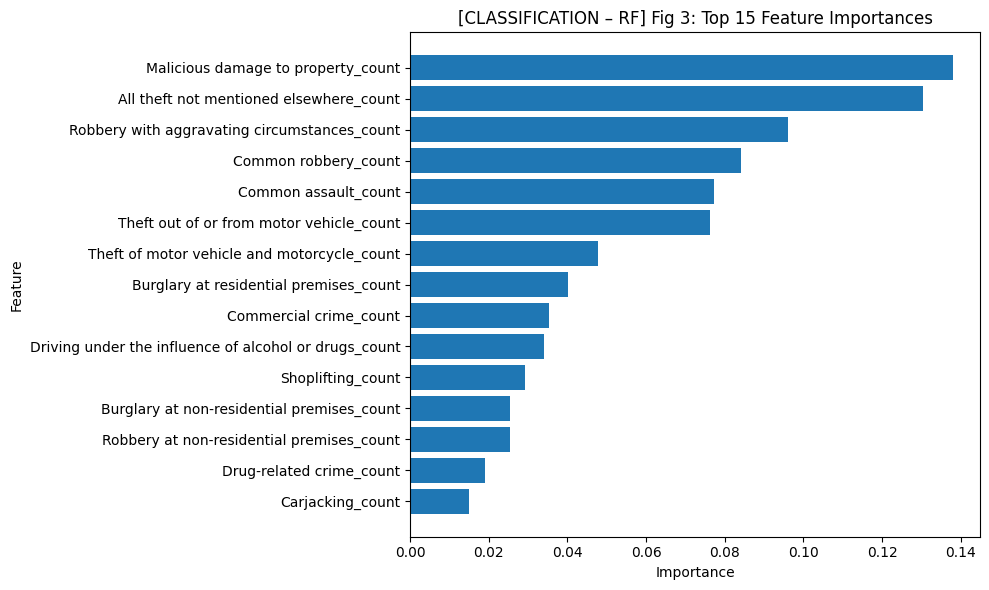

In [ ]:
rf_importance = getattr(rf, "feature_importances_", None)
if rf_importance is not None:
    importances = np.array(rf_importance)
    feat_names = np.array(X.columns)
    order = np.argsort(importances)[::-1][:15]
    fig3 = plt.figure(figsize=(10,6))
    plt.barh(feat_names[order][::-1], importances[order][::-1])
    plt.title("[CLASSIFICATION – RF] Fig 3: Top 15 Feature Importances")
    plt.xlabel("Importance"); plt.ylabel("Feature"); plt.tight_layout()
    maybe_save(fig3, "fig3_rf_feature_importances.png")
    plt.show()

[CLASSIFICATION – RF] Confusion matrix

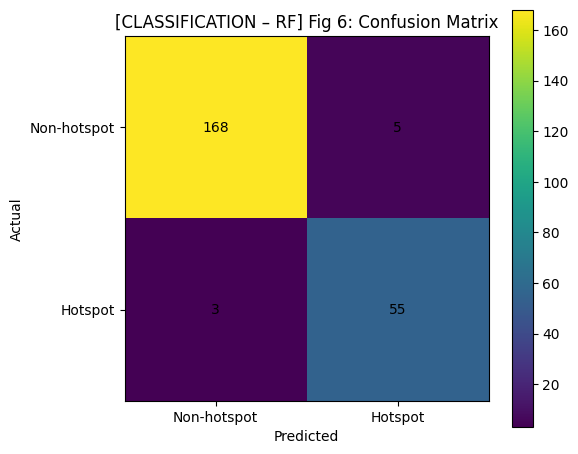

In [ ]:
tick_marks = np.arange(2)
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig6 = plt.figure(figsize=(6,5))
plt.imshow(cm_rf, interpolation="nearest")
plt.title("[CLASSIFICATION – RF] Fig 6: Confusion Matrix")
plt.colorbar()
plt.xticks(tick_marks, ["Non-hotspot","Hotspot"])
plt.yticks(tick_marks, ["Non-hotspot","Hotspot"])
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        plt.text(j, i, cm_rf[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout()
maybe_save(fig6, "fig6_rf_confusion_matrix.png")
plt.show()

switch to True to save PNGs

In [ ]:
SAVE_FIGS = False

def maybe_save(fig, fname):
    if SAVE_FIGS:
        fig.savefig(fname, dpi=150, bbox_inches="tight")


tidy station totals for 2015–2016

In [ ]:
target_year = "2015-2016"
station_totals_2016 = totals_by_station[["Station", "Province", target_year]].copy()
station_totals_2016 = station_totals_2016.sort_values(by=target_year, ascending=False)

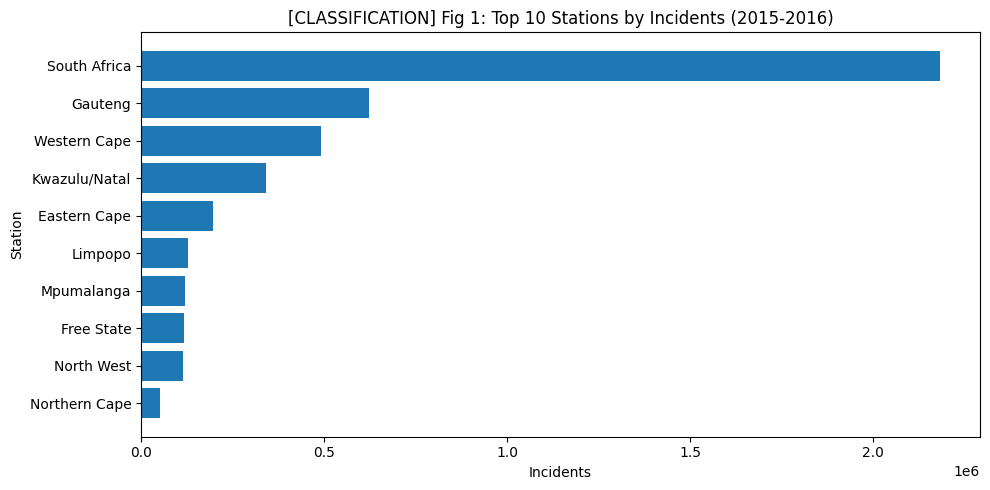

In [ ]:
topN = 10
fig1 = plt.figure(figsize=(10,5))
subset = station_totals_2016.head(topN).iloc[::-1]
plt.barh(subset["Station"], subset[target_year])
plt.title(f"[CLASSIFICATION] Fig 1: Top {topN} Stations by Incidents ({target_year})")
plt.xlabel("Incidents"); plt.ylabel("Station"); plt.tight_layout()
maybe_save(fig1, "fig1_classification_top_stations.png")
plt.show()

FORECASTING

In [ ]:
cat  = FORECAST_CATEGORY
prov = FORECAST_PROVINCE

df_cat = stations[stations["Crime Category"] == cat].copy()
df_cat = df_cat[df_cat["Province"].str.lower() == prov.lower()].copy()

series_annual = df_cat[year_cols].sum()  # province total across stations
ts = series_annual.rename(index={c: end_year(c) for c in year_cols}).sort_index()
ts.index = pd.PeriodIndex(ts.index, freq="Y")
ts = ts.astype(float)

model = ExponentialSmoothing(ts, trend="add", seasonal=None, initialization_method="estimated")
fit = model.fit(optimized=True)

n_ahead = FORECAST_YEARS_AHEAD
fc = fit.forecast(n_ahead)

Simple 95% CI from residuals

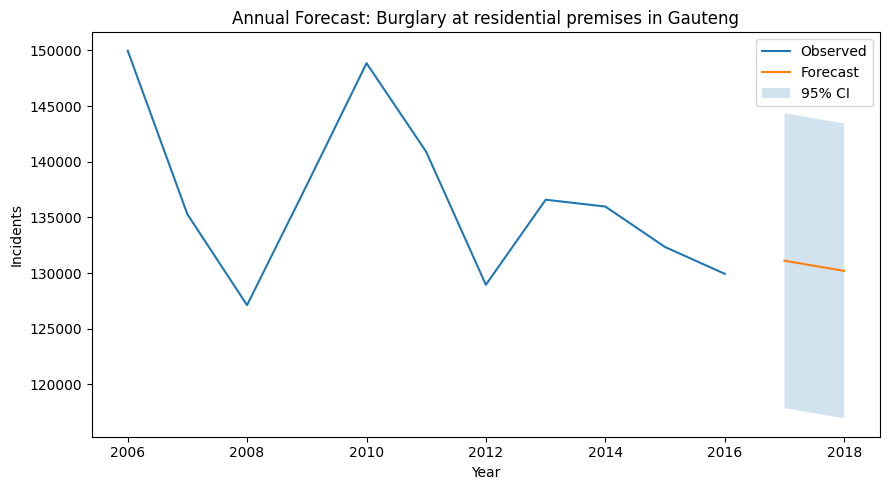

In [ ]:
resid = fit.resid
sigma = resid.std(ddof=1)
ci_low = fc - 1.96 * sigma
ci_high = fc + 1.96 * sigma

plt.figure(figsize=(9,5))
plt.plot(ts.index.to_timestamp(), ts.values, label="Observed")
plt.plot(fc.index.to_timestamp(), fc.values, label="Forecast")
plt.fill_between(fc.index.to_timestamp(), ci_low.values, ci_high.values, alpha=0.2, label="95% CI")
plt.title(f"Annual Forecast: {cat} in {prov}")
plt.xlabel("Year"); plt.ylabel("Incidents"); plt.legend(); plt.tight_layout()
plt.show()

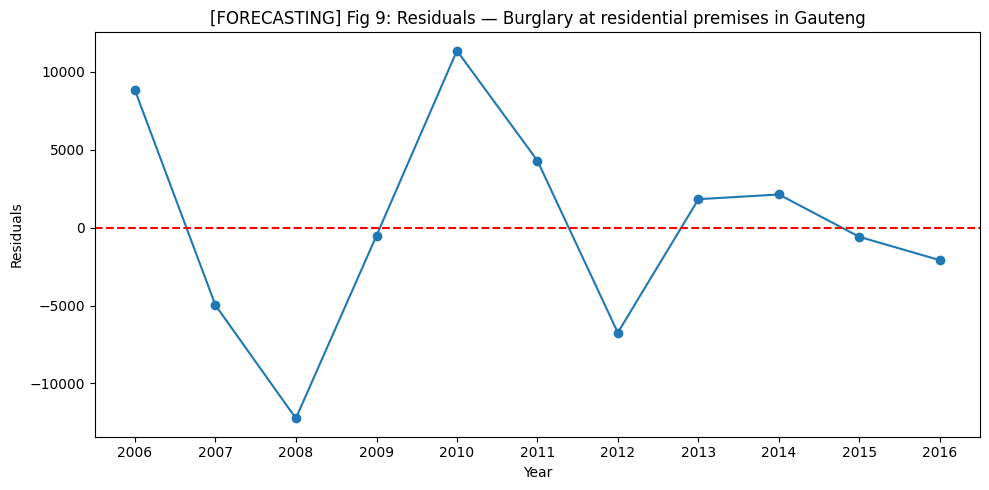

In [ ]:

residuals = fit.resid.copy()
fig9 = plt.figure(figsize=(10,5))
plt.plot(residuals.index.to_timestamp(), residuals.values, marker="o")
plt.axhline(0, color="red", linestyle="--")
plt.title(f"[FORECASTING] Fig 9: Residuals — {FORECAST_CATEGORY} in {FORECAST_PROVINCE}")
plt.xlabel("Year"); plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

Actual vs Fitted scatter

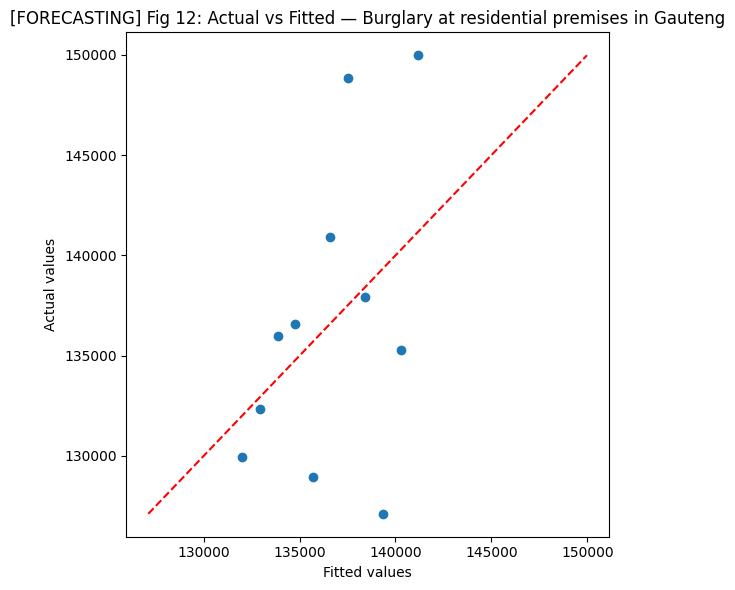

In [ ]:
fitted_vals = fit.fittedvalues

fig12 = plt.figure(figsize=(6,6))
plt.scatter(fitted_vals.values, ts.values)
mn, mx = min(ts.min(), fitted_vals.min()), max(ts.max(), fitted_vals.max())
plt.plot([mn, mx], [mn, mx], "r--")  # 45° line
plt.title(f"[FORECASTING] Fig 12: Actual vs Fitted — {FORECAST_CATEGORY} in {FORECAST_PROVINCE}")
plt.xlabel("Fitted values"); plt.ylabel("Actual values")
plt.tight_layout()
plt.show()

Fitted vs Observed line plot

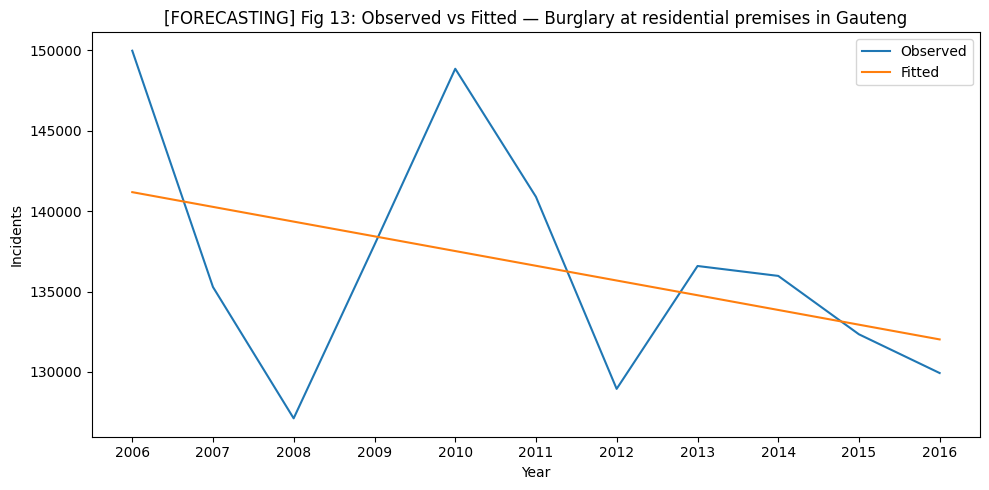

In [ ]:
fig13 = plt.figure(figsize=(10,5))
plt.plot(ts.index.to_timestamp(), ts.values, label="Observed")
plt.plot(fitted_vals.index.to_timestamp(), fitted_vals.values, label="Fitted")
plt.title(f"[FORECASTING] Fig 13: Observed vs Fitted — {FORECAST_CATEGORY} in {FORECAST_PROVINCE}")
plt.xlabel("Year"); plt.ylabel("Incidents"); plt.legend(); plt.tight_layout()
plt.show()

In [ ]:
os.makedirs("artifacts/plots", exist_ok=True)
residuals = fit.resid.copy()

fig9 = plt.figure(figsize=(10,5))
plt.plot(residuals.index.to_timestamp(), residuals.values, marker="o")
plt.axhline(0, color="red", linestyle="--")
plt.title(f"[FORECASTING] Fig 9: Residuals — {FORECAST_CATEGORY} in {FORECAST_PROVINCE}")
plt.xlabel("Year")
plt.ylabel("Residuals")
plt.tight_layout()

# Save to file
save_path = "artifacts/plots/fig9_residuals.png"
fig9.savefig(save_path, dpi=150, bbox_inches="tight")

plt.close(fig9)
print(f"✅ Residuals plot saved as {save_path}")

✅ Residuals plot saved as artifacts/plots/fig9_residuals.png


Drone Programming Simulation.

In my analysis, If I had to simulate a drone visiting crime hotspots, I’d first mark those hotspots as points of interest (POIs). To organize the area, I’d create a grid made up of 1 km × 1 km blocks. Each hotspot would fall into one of those blocks, and I’d also set a flying altitude to make it a proper 3D space. This grid helps me keep track of where the drone needs to go.

Waypoint Generation and Path Planning
TOnce the hotspots are marked, I’d turn them into waypoints – basically, coordinates the drone must pass through. To decide how the drone moves between these points, I’d use one of two approaches:
A lawnmower pattern, where the drone flies row by row across the grid. This works well if I want to scan the whole area.
A nearest-neighbour approach, where the drone always goes to the closest unvisited hotspot. This saves time when the hotspots are spread far apart.
Depending on the layout of the hotspots, I could even mix both methods.

How the Drone Would Fly
To actually fly the drone, I’d load the list of waypoints into flight software like Mission Planner or QGroundControl. The drone would then handle the mission in AUTO mode:
Take off to the right height.
Move from waypoint to waypoint, possibly hovering at each hotspot for observation.
After visiting all hotspots, return back to the starting point or land.
Of course, I’d keep in mind safety factors like battery life, no-fly zones, and obstacles.